In [ ]:
# !pip install rasterio
# !pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.4 MB/s eta 0:00:00


In [ ]:
import rasterio as rio
import rioxarray as rxr
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

In [ ]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))

from config import raw_files, processed_files

/content


ModuleNotFoundError: No module named 'config'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
file_path = processed_files["elevation"] / "Elevation_DZ_TN.tif"
elevation_data = rxr.open_rasterio(file_path, masked=True).squeeze()

### Data Preprocessing
after visulizing the eda, i observed that the outliers are not errors, so we can not simply remove them, instead we can use other methods like log transformation of binning, log transformation is useful when the data is highly skewed, so its not a good fit here, instead i choosed bining (equal width)

In [ ]:
# Convert xarray to pandas DataFrame
elevation_df = elevation_data.to_dataframe(name='elevation').reset_index()


In [ ]:
elevation_df.head()

,y,x,band,spatial_ref,elevation
0,37.560278,-8.673056,1,0,NaN
1,37.560278,-8.668889,1,0,NaN
2,37.560278,-8.664722,1,0,NaN
3,37.560278,-8.660556,1,0,NaN
4,37.560278,-8.656389,1,0,NaN


In [ ]:
elevation_df.isna().sum() / elevation_df.shape[0] * 100

y               0.000000
x               0.000000
band            0.000000
spatial_ref     0.000000
elevation      40.759853
dtype: float64

In [ ]:
elevation_df['elevation'].describe()

count    1.311956e+07
mean     5.384412e+02
std      3.182768e+02
min     -8.720000e+02
25%      3.120000e+02
50%      4.640000e+02
75%      6.980000e+02
max      2.877000e+03
Name: elevation, dtype: float64

removed spatial_ref and band (useless infos)

In [ ]:
elevation_df = elevation_df[['x', 'y', 'elevation']]
elevation_df.head()

KeyError: "['x', 'y'] not in index"

In [ ]:
elevation_df = elevation_df.rename(columns={'x': 'longitude', 'y': 'latitude'})
elevation_df.head()

,latitude,longitude,band,spatial_ref,elevation
0,37.560278,-8.673056,1,0,NaN
1,37.560278,-8.668889,1,0,NaN
2,37.560278,-8.664722,1,0,NaN
3,37.560278,-8.660556,1,0,NaN
4,37.560278,-8.656389,1,0,NaN


remove missing values because they are out of the algeria,tunisia's zones

In [ ]:

kept_df = elevation_df[elevation_df['elevation'].notna()]

In [ ]:
kept_df.head()

,y,x,band,spatial_ref,elevation
9191,37.556111,8.956111,1,0,0.0
14149,37.551944,8.947778,1,0,0.0
29028,37.539444,8.943611,1,0,1.0
29029,37.539444,8.947778,1,0,0.0
33987,37.535278,8.939444,1,0,0.0


In [ ]:
print(kept_df.head(10))
print(len(kept_df))

               y         x  band  spatial_ref  elevation
9191   37.556111  8.956111     1            0        0.0
14149  37.551944  8.947778     1            0        0.0
29028  37.539444  8.943611     1            0        1.0
29029  37.539444  8.947778     1            0        0.0
33987  37.535278  8.939444     1            0        0.0
33988  37.535278  8.943611     1            0       12.0
33989  37.535278  8.947778     1            0        0.0
38942  37.531111  8.918611     1            0        0.0
38943  37.531111  8.922778     1            0        0.0
38944  37.531111  8.926944     1            0        0.0
13119560


In [ ]:
kept_df.describe()

,y,x,band,spatial_ref,elevation
count,1.311956e+07,1.311956e+07,13119560.0,13119560.0,1.311956e+07
mean,2.855396e+01,3.135884e+00,1.0,0.0,5.384412e+02
std,4.410324e+00,4.525084e+00,0.0,0.0,3.182768e+02
min,1.896028e+01,-8.673056e+00,1.0,0.0,-8.720000e+02
25%,2.508111e+01,-6.472222e-02,1.0,0.0,3.120000e+02
50%,2.838528e+01,3.510278e+00,1.0,0.0,4.640000e+02
75%,3.210194e+01,6.772778e+00,1.0,0.0,6.980000e+02
max,3.755611e+01,1.198528e+01,1.0,0.0,2.877000e+03


im gonna use Sturges Formula for binning:

In [ ]:
import numpy as np
import pandas as pd

# Suppose your DataFrame is called elevation_df and the column is 'elevation'
n = len(kept_df['elevation'])


# Sturges' formula
num_bins = int(1 + 3.322 * np.log10(n))

print(f"Number of bins (Sturges formula): {num_bins}")

Number of bins (Sturges formula): 24


In [ ]:
kept_df['elevation_equal_width_bins'] = pd.cut(kept_df['elevation'], bins=num_bins)
print(kept_df.head())

       longitude   latitude  elevation elevation_equal_width_bins
9191    8.956111  37.556111        0.0           (-90.958, 65.25]
14149   8.947778  37.551944        0.0           (-90.958, 65.25]
29028   8.943611  37.539444        1.0           (-90.958, 65.25]
29029   8.947778  37.539444        0.0           (-90.958, 65.25]
33987   8.939444  37.535278        0.0           (-90.958, 65.25]


/tmp/ipykernel_109792/2012330524.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_df['elevation_equal_width_bins'] = pd.cut(kept_df['elevation'], bins=num_bins)


## Equal-width binning 

### smothed by mean

In [ ]:
# Smooth by bin mean
bin_means = kept_df.groupby('elevation_equal_width_bins')['elevation'].mean()
kept_df['elevation_EW_smothed_by_mean'] = kept_df['elevation_equal_width_bins'].map(bin_means)
kept_df['elevation_EW_smothed_by_mean']

/tmp/ipykernel_109792/2971059069.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = kept_df.groupby('elevation_equal_width_bins')['elevation'].mean()
/tmp/ipykernel_109792/2971059069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_df['elevation_EW_smothed_by_mean'] = kept_df['elevation_equal_width_bins'].map(bin_means)


9191         25.104313
14149        25.104313
29028        25.104313
29029        25.104313
33987        25.104313
               ...    
22139363    450.934296
22139364    450.934296
22139365    450.934296
22139366    450.934296
22144322    450.934296
Name: elevation_EW_smothed_by_mean, Length: 13119560, dtype: float32

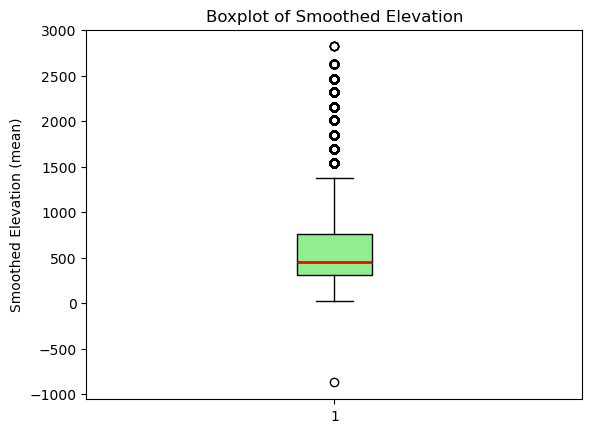

In [ ]:
plt.boxplot(kept_df['elevation_EW_smothed_by_mean'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='red', linewidth=2))

plt.title("Boxplot of Smoothed Elevation")
plt.ylabel("Smoothed Elevation (mean)")
plt.show()

Text(0, 0.5, 'Frequency')

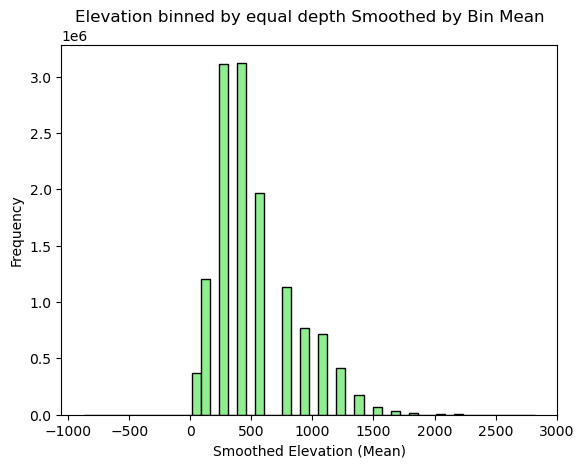

In [ ]:
plt.hist(kept_df['elevation_EW_smothed_by_mean'], bins=50, color='lightgreen', edgecolor='black')
plt.title("Elevation binned by equal depth Smoothed by Bin Mean")
plt.xlabel("Smoothed Elevation (Mean)")
plt.ylabel("Frequency")

### smothed by boundaries

In [ ]:
EW_bins=kept_df["elevation_equal_width_bins"].unique()
EW_bins[1]
# Convert to list of lists
EW_bins = [[interval.left, interval.right] for interval in EW_bins]
EW_bins=np.array(EW_bins)
EW_bins

array([[ -90.958,   65.25 ],
       [  65.25 ,  221.458],
       [ 221.458,  377.667],
       [ 377.667,  533.875],
       [ 533.875,  690.083],
       [ 690.083,  846.292],
       [ 846.292, 1002.5  ],
       [1002.5  , 1158.708],
       [1158.708, 1314.917],
       [1314.917, 1471.125],
       [1471.125, 1627.333],
       [1627.333, 1783.542],
       [1783.542, 1939.75 ],
       [1939.75 , 2095.958],
       [2095.958, 2252.167],
       [2252.167, 2408.375],
       [-875.749, -715.792],
       [2408.375, 2564.583],
       [2564.583, 2720.792],
       [2720.792, 2877.   ]])

In [ ]:
## EW_bins_array is your 2D NumPy array of shape (n_bins, 2)
def smooth_by_boundary(x, bins):
    for bin in bins:  # each bin = [left, right]
        left, right = bin
        if left <= x <= right:
            # find which boundary is closer
            if abs(x - left) <= abs(x - right):
                return left
            else:
                return right
    return x  # if x is outside all bins

# Apply smoothing
kept_df["elevation_EW_smoothed_by_boundaries"] = kept_df["elevation"].apply(
    lambda x: smooth_by_boundary(x, EW_bins)
)



/tmp/ipykernel_109792/1945039320.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_df["elevation_EW_smoothed_by_boundaries"] = kept_df["elevation"].apply(


In [ ]:
kept_df["elevation_EW_smoothed_by_boundaries"]


9191         65.250
14149        65.250
29028        65.250
29029        65.250
33987        65.250
             ...   
22139363    533.875
22139364    533.875
22139365    533.875
22139366    533.875
22144322    533.875
Name: elevation_EW_smoothed_by_boundaries, Length: 13119560, dtype: float64

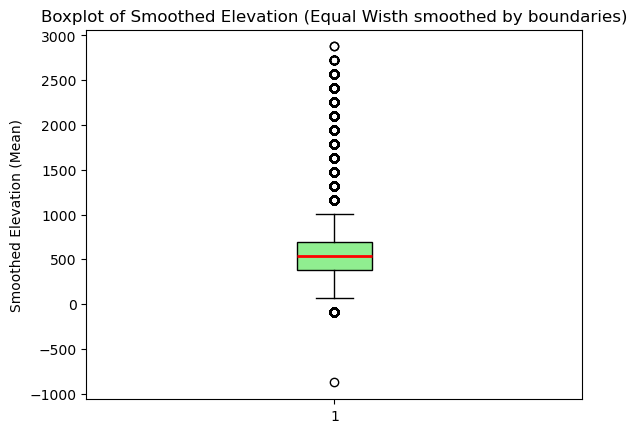

In [ ]:
plt.boxplot(kept_df['elevation_EW_smoothed_by_boundaries'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='red', linewidth=2))

plt.title("Boxplot of Smoothed Elevation (Equal Wisth smoothed by boundaries)")
plt.ylabel("Smoothed Elevation (Mean)")
plt.show()

Text(0, 0.5, 'Frequency')

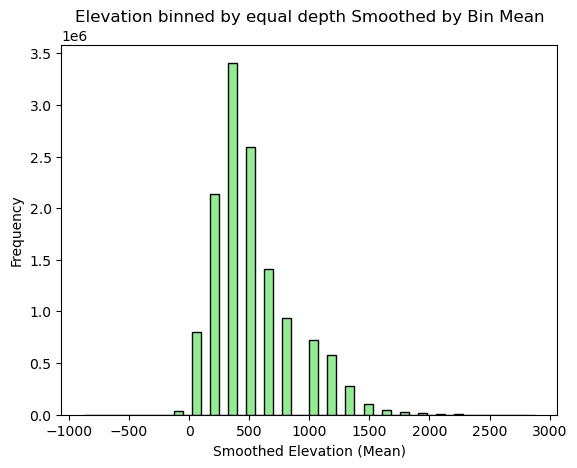

In [ ]:
plt.hist(kept_df['elevation_EW_smoothed_by_boundaries'], bins=50, color='lightgreen', edgecolor='black')
plt.title("Elevation binned by equal depth Smoothed by Bin Mean")
plt.xlabel("Smoothed Elevation (Mean)")
plt.ylabel("Frequency")

## Equal-Depth Binning

### smothed by mean (the best one)

In [ ]:


# Example: compute 4 quantile bins for elevation
_, bin_edges = pd.qcut(kept_df["elevation"], q=4, retbins=True, duplicates="drop")


# Optional: convert to list of lists (intervals)
quantile_bins_list = [[float(bin_edges[i]), float(bin_edges[i+1])] for i in range(len(bin_edges)-1)]
print("Quantile bins :", quantile_bins_list)


Quantile bins : [[-872.0, 312.0], [312.0, 464.0], [464.0, 698.0], [698.0, 2877.0]]


In [ ]:
# Compute mean of each bin
bin_means = [ (b[0] + b[1])/2 for b in quantile_bins_list ]
print("Bin means:", bin_means)


Bin means: [-280.0, 388.0, 581.0, 1787.5]


In [ ]:
def smooth_by_bin_mean(x, bins, bin_means):
    for i, bin in enumerate(bins):
        left, right = bin
        if left <= x <= right:
            return bin_means[i]  # return the mean of that bin
    return x  # if outside all bins


In [ ]:
kept_df["elevation_ED_smoothed_by_mean"] = kept_df["elevation"].apply(
    lambda x: smooth_by_bin_mean(x, quantile_bins_list, bin_means)
)


/tmp/ipykernel_109792/448972229.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_df["elevation_ED_smoothed_by_mean"] = kept_df["elevation"].apply(


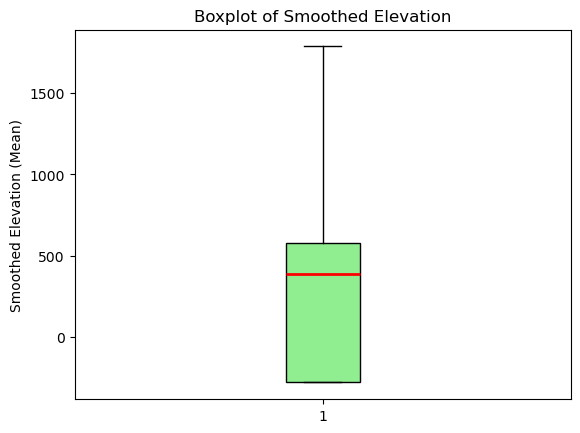

In [ ]:
plt.boxplot(kept_df['elevation_ED_smoothed_by_mean'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='red', linewidth=2))

plt.title("Boxplot of Smoothed Elevation")
plt.ylabel("Smoothed Elevation (Mean)")
plt.show()

Text(0, 0.5, 'Frequency')

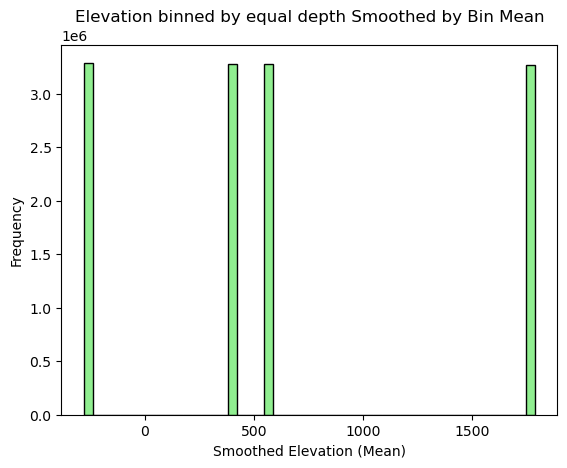

In [ ]:
plt.hist(kept_df['elevation_ED_smoothed_by_mean'], bins=50, color='lightgreen', edgecolor='black')
plt.title("Elevation binned by equal depth Smoothed by Bin Mean")
plt.xlabel("Smoothed Elevation (Mean)")
plt.ylabel("Frequency")

### smothed by boundaries

In [ ]:
kept_df["elevation_ED_smoothed_by_boundaries"] = kept_df["elevation"].apply(
    lambda x: smooth_by_boundary(x, quantile_bins_list)
)


/tmp/ipykernel_109792/1686590008.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_df["elevation_ED_smoothed_by_boundaries"] = kept_df["elevation"].apply(


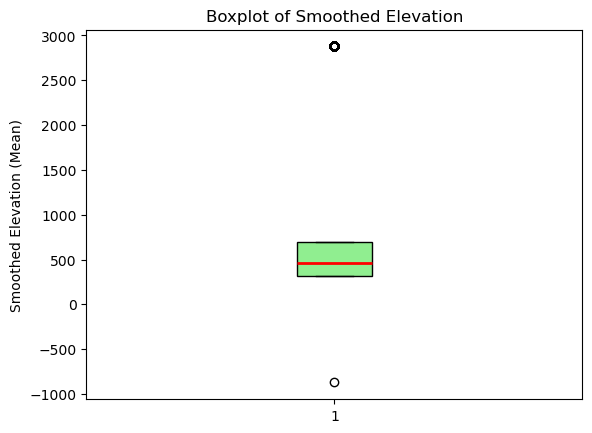

In [ ]:
plt.boxplot(kept_df['elevation_ED_smoothed_by_boundaries'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='red', linewidth=2))

plt.title("Boxplot of Smoothed Elevation")
plt.ylabel("Smoothed Elevation (Mean)")
plt.show()

Text(0, 0.5, 'Frequency')

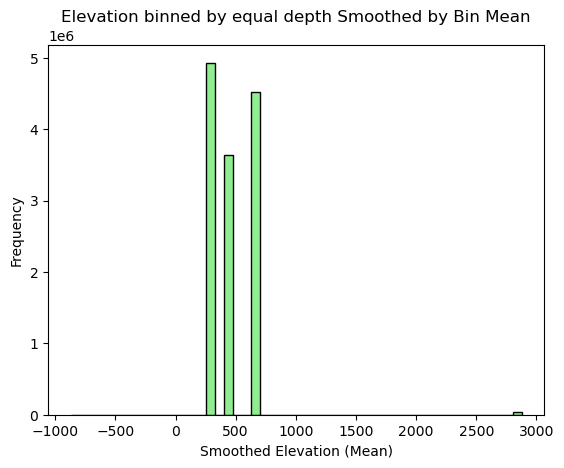

In [ ]:
plt.hist(kept_df['elevation_ED_smoothed_by_boundaries'], bins=50, color='lightgreen', edgecolor='black')
plt.title("Elevation binned by equal depth Smoothed by Bin Mean")
plt.xlabel("Smoothed Elevation (Mean)")
plt.ylabel("Frequency")

the best one is equal depth smothed by mean

In [ ]:
kept_df.head()


,longitude,latitude,elevation,elevation_equal_width_bins,elevation_EW_smothed_by_mean,elevation_EW_smoothed_by_boundaries,elevation_ED_smoothed_by_mean,elevation_ED_smoothed_by_boundaries
9191,8.956111,37.556111,0.0,"(-90.958, 65.25]",25.104313,65.25,-280.0,312.0
14149,8.947778,37.551944,0.0,"(-90.958, 65.25]",25.104313,65.25,-280.0,312.0
29028,8.943611,37.539444,1.0,"(-90.958, 65.25]",25.104313,65.25,-280.0,312.0
29029,8.947778,37.539444,0.0,"(-90.958, 65.25]",25.104313,65.25,-280.0,312.0
33987,8.939444,37.535278,0.0,"(-90.958, 65.25]",25.104313,65.25,-280.0,312.0


In [ ]:
kept_df = kept_df.rename(columns={'y':'latitude', 'x':'longitude'})

In [ ]:
kept_df.drop(columns=['elevation', 'elevation_equal_width_bins', 'elevation_EW_smothed_by_mean', 'elevation_EW_smoothed_by_boundaries', 'elevation_ED_smoothed_by_boundaries'], inplace=True)

In [ ]:
from config import latitude_lower_bound
kept_df = kept_df[kept_df['latitude'] > latitude_lower_bound]
kept_df

,longitude,latitude,elevation_ED_smoothed_by_mean
9191,8.956111,37.556111,-280.0
14149,8.947778,37.551944,-280.0
29028,8.943611,37.539444,-280.0
29029,8.947778,37.539444,-280.0
33987,8.939444,37.535278,-280.0
...,...,...,...
12325068,9.776944,27.210278,581.0
12325069,9.781111,27.210278,581.0
12325070,9.785278,27.210278,581.0
12325071,9.789444,27.210278,581.0


In [ ]:
kept_df.to_csv('../../data/pre-merge/elevation.csv', index=False)